## 实战Kaggle比赛——使用Gluon预测房价和K折交叉验证
本章介绍如何使用Gluon来实战Kaggle比赛。我们以[房价预测](http://zh.gluon.ai/chapter_supervised-learning/kaggle-gluon-kfold.html#%E5%AE%9E%E6%88%98Kaggle%E6%AF%94%E8%B5%9B%E2%80%94%E2%80%94%E4%BD%BF%E7%94%A8Gluon%E9%A2%84%E6%B5%8B%E6%88%BF%E4%BB%B7%E5%92%8CK%E6%8A%98%E4%BA%A4%E5%8F%89%E9%AA%8C%E8%AF%81)问题为例，为大家提供一整套实战中常常需要的工具，例如K折交叉验证。我们还以pandas为工具介绍如何对真实世界中的数据进行重要的预处理，例如：

- 处理离散数据

- 处理丢失的数据特征

- 对数据进行标准化

需要注意的是，本章仅提供一些基本实战流程供大家参考。对于数据的预处理、模型的设计和参数的选择等，我们特意只提供最基础的版本。希望大家一定要通过动手实战、仔细观察实验现象、认真分析实验结果并不断调整方法，从而得到令自己满意的结果。

这是一次宝贵的实战机会，我们相信你一定能从动手的过程中学到很多。

Get your hands dirty。

## Kaggle中的房价预测问题

Kaggle是一个著名的供机器学习爱好者交流的平台。为了便于提交结果，请大家注册Kaggle账号。请注意，目前Kaggle仅限每个账号一天以内10次提交结果的机会。所以提交结果前务必三思


![image.png](http://zh.gluon.ai/_images/kaggle.png)
我们以房价预测问题为例教大家如何实战一次Kaggle比赛。请大家在动手开始之前点击房价预测问题了解相关信息。
![image.png](http://zh.gluon.ai/_images/house_pricing.png)

### 读入数据
比赛数据分为训练数据集和测试数据集。两个数据集都包括每个房子的特征，例如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值’na’。只有训练数据集包括了我们需要在测试数据集中预测的每个房子的价格。数据可以从房价预测问题中下载。

[训练数据集下载地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv) [测试数据集下载地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/test.csv)

我们通过使用pandas读入数据。请确保安装了pandas (pip install pandas)。



In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))


我们看看数据长什么样子。



In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


数据大小如下。



In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

### 预处理数据
我们使用pandas对数值特征做标准化处理：

$x_i = \frac{x_i - \mathbb{E} x_i}{\text{std}(x_i)}$。

In [5]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean()) / (x.std()))
print all_X.head()

   MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0    0.067320       RL    -0.184443 -0.217841   Pave   NaN      Reg   
1   -0.873466       RL     0.458096 -0.072032   Pave   NaN      Reg   
2    0.067320       RL    -0.055935  0.137173   Pave   NaN      IR1   
3    0.302516       RL    -0.398622 -0.078371   Pave   NaN      IR1   
4    0.067320       RL     0.629439  0.518814   Pave   NaN      IR1   

  LandContour Utilities LotConfig      ...       ScreenPorch  PoolArea PoolQC  \
0         Lvl    AllPub    Inside      ...         -0.285886 -0.063139    NaN   
1         Lvl    AllPub       FR2      ...         -0.285886 -0.063139    NaN   
2         Lvl    AllPub    Inside      ...         -0.285886 -0.063139    NaN   
3         Lvl    AllPub    Corner      ...         -0.285886 -0.063139    NaN   
4         Lvl    AllPub       FR2      ...         -0.285886 -0.063139    NaN   

  Fence MiscFeature   MiscVal    MoSold    YrSold  SaleType  SaleCondition  
0   NaN  

现在把离散数据点转换成数值标签。

In [6]:
all_X = pd.get_dummies(all_X, dummy_na=True)

把缺失数据用本特征的平均值估计。



In [7]:
print all_X.mean()
all_X = all_X.fillna(all_X.mean())
#print all_X.head()

MSSubClass               9.015570e-17
LotFrontage              3.058133e-16
LotArea                  8.286737e-18
OverallQual             -4.176173e-16
OverallCond              1.500075e-16
YearBuilt               -6.544953e-16
YearRemodAdd             5.639925e-16
MasVnrArea              -4.573297e-16
BsmtFinSF1               9.793400e-17
BsmtFinSF2              -8.971576e-17
BsmtUnfSF                7.495337e-17
TotalBsmtSF             -1.108130e-17
1stFlrSF                -1.286322e-16
2ndFlrSF                -1.991479e-16
LowQualFinSF            -1.871081e-15
GrLivArea                1.416019e-16
BsmtFullBath             1.010124e-16
BsmtHalfBath             2.993644e-16
FullBath                 1.428951e-16
HalfBath                 8.702262e-17
BedroomAbvGr             2.030655e-16
KitchenAbvGr            -4.203177e-16
TotRmsAbvGrd             3.128707e-16
Fireplaces              -9.558035e-17
GarageYrBlt             -9.770767e-17
GarageCars               4.734618e-16
GarageArea  

In [8]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()
print X_train[0]

[ 0.06731988 -0.18444262 -0.21784137  0.6460727  -0.5071973   1.04607837
  0.8966793   0.52303833  0.58070781 -0.29302957 -0.93454221 -0.44417553
 -0.77372846  1.20717172 -0.10117968  0.41347637  1.08646381 -0.24976672
  0.78123196  1.23238772  0.16989798 -0.20766289  0.98668031 -0.92415287
  0.97311008  0.30642276  0.34878012 -0.74063351  0.19997175 -0.35953915
 -0.10331283 -0.28588648 -0.06313936 -0.08957661 -1.55191764  0.15761852
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

### 导入NDArray格式数据
为了便于和Gluon交互，我们需要导入NDArray格式数据。



In [9]:
import numpy as np
import random 

X_train = np.array(X_train)
y_train = np.array(y_train)
y_train.reshape((num_train, 1))
X_test = np.array(X_test)

def data_iter(X, y, batch_size, num_epochs, shuffle=True):
    # 产生一个随机索引
    num_examples = X.shape[0]
    idx = list(range(num_examples*num_epochs))
    if shuffle:
        random.shuffle(idx)
    batch_X = []
    batch_y = []
    for i in idx:
        i %= num_examples
        batch_X.append(X[i])
        batch_y.append(y[i])
        if len(batch_X) == batch_size:
            yield np.array(batch_X), np.array(batch_y)
            batch_X = []
            batch_y = []


我们定义比赛中测量结果用的函数。



In [10]:
import tensorflow as tf

def get_rmse_log(yhat, y):
    num_train = y.shape[0]
    yhat = tf.clip_by_value(yhat, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(tf.square(tf.log(yhat) - tf.log(y))))

### 定义模型
我们将模型的定义放在一个函数里供多次调用。这是一个基本的线性回归模型。



In [11]:
def net(X):
    with tf.name_scope('linear_regression'):
        yhat = tf.contrib.layers.fully_connected(X, 1, activation_fn=None)
    return yhat

我们定义一个训练的函数，这样在跑不同的实验时不需要重复实现相同的步骤。



In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(X_train, y_train, X_test, y_test, epochs,
          verbose_step, learning_rate, weight_decay):
    tf.reset_default_graph()
    batch_size = 100
    train_loss = []
    if X_test is not None:
        test_loss = []
    data_iter_train = data_iter(X_train, y_train, batch_size, epochs, shuffle=True)
    input_placeholder = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    gt_placeholder = tf.placeholder(tf.float32, [None])
    yhat = net(input_placeholder)
    mse = tf.losses.mean_squared_error(gt_placeholder, tf.squeeze(yhat))
    for var in tf.all_variables():
        mse += weight_decay * tf.nn.l2_loss(var)
    #train_op = tf.train.AdamOptimizer(learning_rate).minimize(mse)
    rmse = get_rmse_log(tf.squeeze(yhat), gt_placeholder)

    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(mse)
    
    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    step = 0
    for data, label in data_iter_train:
        mse_, rmse_, yhat_,  _ = sess.run([mse, rmse, yhat, train_op], feed_dict={input_placeholder: data, gt_placeholder: label})
        if step % verbose_step == 0:
            print("step %d, train loss: %f" % (step, rmse_))
            train_loss.append(rmse_)
            if X_test is not None and y_test is not None:
                test_rmse_, test_yhat_ = sess.run([rmse, yhat], feed_dict={input_placeholder: X_test, gt_placeholder: y_test})
                test_loss.append(test_rmse_)
        step += 1
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None and y_test is not None:
        return rmse_, test_rmse_, test_yhat_

    if X_test is not None:
        predict_yhat = sess.run(yhat, feed_dict={input_placeholder: X_test})
        return predict_yhat
    else:
        return rmse_

## K折交叉验证

在过拟合中我们讲过，过度依赖训练数据集的误差来推断测试数据集的误差容易导致过拟合。事实上，当我们调参时，往往需要基于K折交叉验证。

在K折交叉验证中，我们把初始采样分割成KK个子样本，一个单独的子样本被保留作为验证模型的数据，其他K−1个样本用来训练。

我们关心K次验证模型的测试结果的平均值和训练误差的平均值，因此我们定义K折交叉验证函数如下。




In [13]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = np.concatenate((X_val_train, X_cur_fold), 0)
                    y_val_train = np.concatenate((y_val_train, y_cur_fold), 0)
        train_loss, test_loss, test_yhat = train(
            X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

### 训练模型并交叉验证
以下的模型参数都是可以调的。



In [14]:
k = 5
epochs = 2000
verbose_epoch = 100
learning_rate = 0.005
weight_decay = 0.0

给定以上调好的参数，接下来我们训练并交叉验证我们的模型。



Instructions for updating:
Please use tf.global_variables instead.
step 0, train loss: 12.041246
step 100, train loss: 0.151103
step 200, train loss: 0.138934
step 300, train loss: 1.071251
step 400, train loss: 0.113411
step 500, train loss: 1.071612
step 600, train loss: 0.124958
step 700, train loss: 0.151833
step 800, train loss: 0.132270
step 900, train loss: 0.160640
step 1000, train loss: 0.178125
step 1100, train loss: 0.135677
step 1200, train loss: 0.138064
step 1300, train loss: 0.126237
step 1400, train loss: 0.136134
step 1500, train loss: 0.132249
step 1600, train loss: 0.169968
step 1700, train loss: 0.122050
step 1800, train loss: 0.123914
step 1900, train loss: 0.149102
step 2000, train loss: 0.110362
step 2100, train loss: 0.171239
step 2200, train loss: 0.128134
step 2300, train loss: 0.151768
step 2400, train loss: 0.091769
step 2500, train loss: 0.105059
step 2600, train loss: 0.111639
step 2700, train loss: 0.108661
step 2800, train loss: 0.103281
step 2900, train

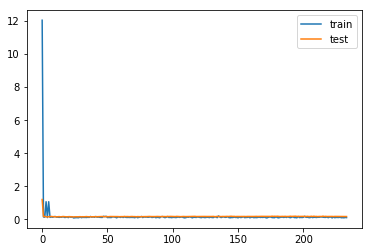

Test loss: 0.175609
step 0, train loss: 12.048615
step 100, train loss: 0.230225
step 200, train loss: 0.274341
step 300, train loss: 0.100598
step 400, train loss: 0.134173
step 500, train loss: 0.181296
step 600, train loss: 0.104731
step 700, train loss: 0.133255
step 800, train loss: 0.183080
step 900, train loss: 0.135950
step 1000, train loss: 0.112655
step 1100, train loss: 0.136337
step 1200, train loss: 0.158480
step 1300, train loss: 0.132105
step 1400, train loss: 0.132699
step 1500, train loss: 0.142625
step 1600, train loss: 0.114097
step 1700, train loss: 0.127950
step 1800, train loss: 0.164097
step 1900, train loss: 0.153213
step 2000, train loss: 0.141671
step 2100, train loss: 0.147271
step 2200, train loss: 0.150746
step 2300, train loss: 0.123627
step 2400, train loss: 0.092863
step 2500, train loss: 0.106809
step 2600, train loss: 0.108614
step 2700, train loss: 0.127648
step 2800, train loss: 0.128616
step 2900, train loss: 0.114564
step 3000, train loss: 0.152505

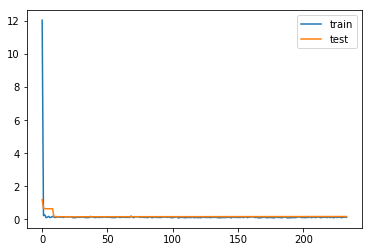

Test loss: 0.171426
step 0, train loss: 11.945149
step 100, train loss: 0.194747
step 200, train loss: 0.128341
step 300, train loss: 0.180620
step 400, train loss: 0.480232
step 500, train loss: 0.120390
step 600, train loss: 0.153840
step 700, train loss: 0.124008
step 800, train loss: 0.122985
step 900, train loss: 0.152455
step 1000, train loss: 0.118578
step 1100, train loss: 0.132838
step 1200, train loss: 0.121395
step 1300, train loss: 0.122798
step 1400, train loss: 0.131325
step 1500, train loss: 0.150240
step 1600, train loss: 0.137654
step 1700, train loss: 0.159353
step 1800, train loss: 0.161505
step 1900, train loss: 0.112229
step 2000, train loss: 0.132513
step 2100, train loss: 0.111177
step 2200, train loss: 0.113116
step 2300, train loss: 0.127969
step 2400, train loss: 0.166040
step 2500, train loss: 0.132066
step 2600, train loss: 0.119497
step 2700, train loss: 0.113026
step 2800, train loss: 0.103234
step 2900, train loss: 0.133381
step 3000, train loss: 0.135016

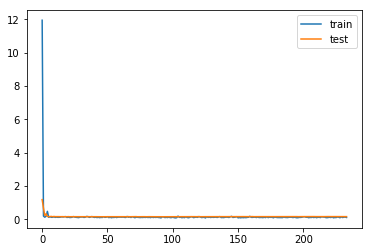

Test loss: 0.162571
step 0, train loss: 12.063858
step 100, train loss: 0.162381
step 200, train loss: 0.207259
step 300, train loss: 0.210021
step 400, train loss: 0.134055
step 500, train loss: 0.131868
step 600, train loss: 0.137100
step 700, train loss: 0.223233
step 800, train loss: 0.171171
step 900, train loss: 0.126005
step 1000, train loss: 0.166022
step 1100, train loss: 0.174076
step 1200, train loss: 0.166218
step 1300, train loss: 0.103834
step 1400, train loss: 0.127297
step 1500, train loss: 0.184083
step 1600, train loss: 0.145292
step 1700, train loss: 0.137035
step 1800, train loss: 0.123510
step 1900, train loss: 0.122180
step 2000, train loss: 0.159772
step 2100, train loss: 0.163271
step 2200, train loss: 0.151566
step 2300, train loss: 0.144381
step 2400, train loss: 0.164252
step 2500, train loss: 0.124821
step 2600, train loss: 0.145619
step 2700, train loss: 0.158542
step 2800, train loss: 0.135301
step 2900, train loss: 0.154223
step 3000, train loss: 0.107341

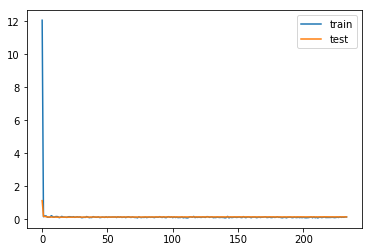

Test loss: 0.150814
step 0, train loss: 12.000143
step 100, train loss: 0.147951
step 200, train loss: 0.206299
step 300, train loss: 1.066505
step 400, train loss: 0.124806
step 500, train loss: 0.108524
step 600, train loss: 0.124775
step 700, train loss: 0.116571
step 800, train loss: 0.115733
step 900, train loss: 0.144928
step 1000, train loss: 0.131320
step 1100, train loss: 0.127065
step 1200, train loss: 0.124333
step 1300, train loss: 0.154700
step 1400, train loss: 0.125209
step 1500, train loss: 0.141372
step 1600, train loss: 0.121844
step 1700, train loss: 0.127371
step 1800, train loss: 0.128685
step 1900, train loss: 0.122759
step 2000, train loss: 0.107953
step 2100, train loss: 0.113234
step 2200, train loss: 0.109282
step 2300, train loss: 0.093187
step 2400, train loss: 0.122329
step 2500, train loss: 0.110884
step 2600, train loss: 0.139881
step 2700, train loss: 0.098876
step 2800, train loss: 0.161091
step 2900, train loss: 0.121864
step 3000, train loss: 0.128922

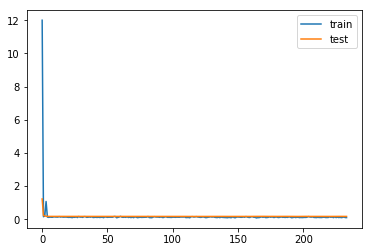

Test loss: 0.165495
5-fold validation: Avg train loss: 0.112949, Avg test loss: 0.165183


In [15]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

即便训练误差可以达到很低（调好参数之后），但是K折交叉验证上的误差可能更高。当训练误差特别低时，要观察K折交叉验证上的误差是否同时降低并小心过拟合。我们通常依赖K折交叉验证误差结果来调节参数。
### 预测并在Kaggle提交预测结果（选学）
本部分为选学内容。网络不好的同学可以通过上述K折交叉验证的方法来评测自己训练的模型。

我们首先定义预测函数。




In [16]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    test_yhat= train(X_train, y_train, X_test, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = test_yhat
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

调好参数以后，下面我们预测并在Kaggle提交预测结果。



step 0, train loss: 12.082478
step 100, train loss: 0.219424
step 200, train loss: 1.120250
step 300, train loss: 0.152886
step 400, train loss: 0.138535
step 500, train loss: 0.146012
step 600, train loss: 0.129160
step 700, train loss: 0.119089
step 800, train loss: 0.142142
step 900, train loss: 0.103008
step 1000, train loss: 0.119038
step 1100, train loss: 0.183590
step 1200, train loss: 0.111835
step 1300, train loss: 0.101762
step 1400, train loss: 0.147491
step 1500, train loss: 0.127234
step 1600, train loss: 0.144823
step 1700, train loss: 0.121905
step 1800, train loss: 0.145800
step 1900, train loss: 0.188396
step 2000, train loss: 0.135064
step 2100, train loss: 0.119648
step 2200, train loss: 0.162503
step 2300, train loss: 0.112073
step 2400, train loss: 0.108659
step 2500, train loss: 0.123440
step 2600, train loss: 0.134616
step 2700, train loss: 0.125547
step 2800, train loss: 0.117411
step 2900, train loss: 0.134315
step 3000, train loss: 0.097096
step 3100, train lo

step 25300, train loss: 0.116296
step 25400, train loss: 0.148814
step 25500, train loss: 0.096156
step 25600, train loss: 0.114050
step 25700, train loss: 0.114724
step 25800, train loss: 0.115034
step 25900, train loss: 0.164720
step 26000, train loss: 0.100686
step 26100, train loss: 0.134332
step 26200, train loss: 0.120155
step 26300, train loss: 0.119674
step 26400, train loss: 0.093240
step 26500, train loss: 0.103451
step 26600, train loss: 0.137472
step 26700, train loss: 0.162250
step 26800, train loss: 0.109099
step 26900, train loss: 0.113986
step 27000, train loss: 0.160048
step 27100, train loss: 0.146144
step 27200, train loss: 0.130530
step 27300, train loss: 0.118316
step 27400, train loss: 0.123653
step 27500, train loss: 0.100588
step 27600, train loss: 0.133973
step 27700, train loss: 0.104179
step 27800, train loss: 0.107815
step 27900, train loss: 0.101661
step 28000, train loss: 0.136123
step 28100, train loss: 0.137129
step 28200, train loss: 0.120553
step 28300

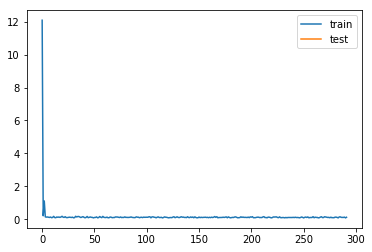

In [17]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)

执行完上述代码后，会生成一个submission.csv文件。这是Kaggle要求的提交格式。这时我们可以在Kaggle上把我们预测得出的结果提交并查看与测试数据集上真实房价的误差。你需要登录Kaggle网站，打开[房价预测问题地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)，并点击下方右侧Submit Predictions按钮提交。
![image.png](http://zh.gluon.ai/_images/kaggle_submit.png)
请点击下方Upload Submission File选择需要提交的预测结果。然后点击下方的Make Submission按钮就可以查看结果啦！
![image.png](http://zh.gluon.ai/_images/kaggle_submit2.png)